In [18]:
import os
import random
import shutil
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models, datasets
from PIL import Image

In [19]:
# ---------- 配置区 ----------
TOP_DIR = Path("image_dataset_project")   # 项目根目录
RAW_DIR = TOP_DIR / "raw_images"          # 原始爬取图片
DATA_DIR = TOP_DIR / "data"               # 整理后按类存放的目录（train/val 子目录）
RESULTS_DIR = TOP_DIR / "results"
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [20]:
# 自选主题与类别
categories = ["butterfly", "moth", "dragonfly"]  # 最少 3 类
num_per_class = 80   # 每类至少 50，建议 80 或更多提高泛化

In [21]:
# 爬虫选项（使用 icrawler 的 Baidu 或 Bing 或 Google）
CRAWL_BACKEND = "baidu"  # 可选: "bing", "google", "baidu" (需要相应 icrawler support)

In [22]:
# 训练超参
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 15
LEARNING_RATE = 1e-3
VAL_SPLIT = 0.2
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [34]:
# ---------- 爬取图片（icrawler） ----------
# 注意：在某些环境，google/bing 爬取需要网络和防护，若不方便可手动准备图片文件夹。
def crawl_images(categories, num_per_class, raw_dir, backend="bing", max_retries=3, timeout=30):
    from icrawler.builtin import BingImageCrawler, GoogleImageCrawler, BaiduImageCrawler
    import time

    for cat in categories:
        target_dir = Path(raw_dir) / cat
        target_dir.mkdir(parents=True, exist_ok=True)
        print(f"爬取类别: {cat} -> {target_dir} (目标 {num_per_class})")

        # 配置爬虫参数
        crawler_kwargs = {
            'storage': {'root_dir': str(target_dir)},
            'log_level': 'INFO'
        }

        # 为不同的后端设置不同的配置
        if backend == "bing":
            # Bing爬虫可以设置超时和线程数
            crawler = BingImageCrawler(**crawler_kwargs)
            # 设置额外的下载器参数
            crawler.downloader.download_timeout = timeout
        elif backend == "google":
            crawler = GoogleImageCrawler(parser_threads=2, downloader_threads=4, **crawler_kwargs)
            crawler.downloader.download_timeout = timeout
        elif backend == "baidu":
            crawler = BaiduImageCrawler(**crawler_kwargs)
            crawler.downloader.download_timeout = timeout
        else:
            raise ValueError("Unsupported backend")

        # 添加重试机制
        retry_count = 0
        while retry_count < max_retries:
            try:
                print(f"尝试 {retry_count+1}/{max_retries}")
                # 先获取当前已有的文件数量
                existing_files = list(target_dir.glob("*.jpg"))
                existing_count = len(existing_files)

                # 如果已经有足够的文件，就跳过
                if existing_count >= num_per_class:
                    print(f"✓ 已达到目标数量 ({existing_count}张)")
                    break

                # 计算还需要爬取的数量
                remaining = num_per_class - existing_count
                print(f"需要再爬取 {remaining} 张图片")

                # 执行爬取
                crawler.crawl(
                    keyword=cat,
                    max_num=num_per_class,
                    min_size=(200, 200),
                    file_idx_offset=existing_count  # 从现有数量开始编号
                )

                # 再次检查文件数量
                final_count = len(list(target_dir.glob("*.jpg")))
                print(f"本轮爬取完成，当前共有 {final_count} 张图片")

                # 如果达到目标数量，就退出循环
                if final_count >= num_per_class:
                    print(f"✓ 成功达到目标数量")
                    break

                # 如果没达到目标数量，但已经爬了一些，也继续尝试
                if final_count > existing_count:
                    retry_count += 1
                    print(f"需要继续爬取，等待5秒后重试...")
                    time.sleep(5)
                else:
                    # 如果一张都没爬到，可能是网络问题，增加等待时间
                    retry_count += 1
                    wait_time = min(10 * retry_count, 60)
                    print(f"未爬取到新图片，等待 {wait_time} 秒后重试...")
                    time.sleep(wait_time)

            except Exception as e:
                retry_count += 1
                print(f"爬取出错: {str(e)}")
                wait_time = min(10 * retry_count, 60)
                print(f"等待 {wait_time} 秒后重试...")
                time.sleep(wait_time)

        final_count = len(list(target_dir.glob("*.jpg")))
        print(f"类别 {cat} 爬取完成: 共 {final_count}/{num_per_class} 张图片")
        print("-" * 50)


# 运行爬虫
crawl_images(categories, num_per_class, RAW_DIR, CRAWL_BACKEND)

2025-11-20 17:10:43,295 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:10:43,295 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:10:43,297 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:10:43,298 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:10:43,300 - INFO - icrawler.crawler - starting 1 downloader threads...


爬取类别: butterfly -> image_dataset_project\raw_images\butterfly (目标 80)
尝试 1/3
需要再爬取 80 张图片


2025-11-20 17:10:43,884 - INFO - parser - parsing result page https://www.bing.com/images/async?q=butterfly&first=0
2025-11-20 17:10:44,028 - INFO - downloader - image #1	https://c-ssl.dtstatic.com/uploads/blog/202102/14/20210214222314_ca7ed.thumb.1000_0.jpg
2025-11-20 17:10:44,231 - INFO - downloader - image #2	https://pic.616pic.com/ys_bnew_img/00/44/77/XKLLHT2YWo.jpg
2025-11-20 17:10:44,688 - INFO - downloader - image #3	https://static.plusequalone.com/gatsby/static/13c0af72225269289abcf628a1b79cb1/30546/butterfly.jpg
2025-11-20 17:10:44,895 - INFO - downloader - image #4	https://puui.qpic.cn/vpic_cover/f0020bc2x0y/f0020bc2x0y_hz.jpg
2025-11-20 17:10:45,358 - INFO - downloader - image #5	https://cdn.britannica.com/76/151376-050-13586FE2/monarch-butterfly-flowers-bush.jpg
2025-11-20 17:10:46,182 - INFO - downloader - image #6	https://www.butterflyidentification.com/wp-content/uploads/2020/02/Butterfly-Facts.jpg
2025-11-20 17:10:51,193 - ERROR - downloader - Exception caught when down

本轮爬取完成，当前共有 21 张图片
需要继续爬取，等待5秒后重试...


2025-11-20 17:12:35,339 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:12:35,339 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:12:35,340 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:12:35,341 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:12:35,342 - INFO - icrawler.crawler - starting 1 downloader threads...


尝试 2/3
需要再爬取 59 张图片


2025-11-20 17:12:37,346 - INFO - parser - no more page urls for thread parser-001 to parse
2025-11-20 17:12:37,347 - INFO - parser - thread parser-001 exit
2025-11-20 17:12:40,345 - INFO - downloader - no more download task for thread downloader-001
2025-11-20 17:12:40,346 - INFO - downloader - thread downloader-001 exit
2025-11-20 17:12:41,346 - INFO - icrawler.crawler - Crawling task done!


本轮爬取完成，当前共有 21 张图片
未爬取到新图片，等待 20 秒后重试...


2025-11-20 17:13:01,348 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:13:01,348 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:13:01,349 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:13:01,350 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:13:01,351 - INFO - icrawler.crawler - starting 1 downloader threads...


尝试 3/3
需要再爬取 59 张图片


2025-11-20 17:13:03,366 - INFO - parser - no more page urls for thread parser-001 to parse
2025-11-20 17:13:03,381 - INFO - parser - thread parser-001 exit
2025-11-20 17:13:06,353 - INFO - downloader - no more download task for thread downloader-001
2025-11-20 17:13:06,355 - INFO - downloader - thread downloader-001 exit
2025-11-20 17:13:07,355 - INFO - icrawler.crawler - Crawling task done!


本轮爬取完成，当前共有 21 张图片
未爬取到新图片，等待 30 秒后重试...


2025-11-20 17:13:37,358 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:13:37,358 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:13:37,359 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:13:37,376 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:13:37,378 - INFO - icrawler.crawler - starting 1 downloader threads...


类别 butterfly 爬取完成: 共 21/80 张图片
--------------------------------------------------
爬取类别: moth -> image_dataset_project\raw_images\moth (目标 80)
尝试 1/3
需要再爬取 80 张图片


2025-11-20 17:13:38,141 - INFO - parser - parsing result page https://www.bing.com/images/async?q=moth&first=0
2025-11-20 17:13:38,868 - ERROR - downloader - Response status code 406, file https://www.dispatch.com/gcdn/presto/2023/06/13/NCOD/80dcb48d-a3f8-426b-8488-ddb1f375366f-Dot-lined_White_Moth._Jim_McCormac.jpg
2025-11-20 17:13:39,866 - INFO - downloader - image #1	https://cdn.pixabay.com/photo/2016/10/13/07/08/moth-1736955_1280.jpg
2025-11-20 17:13:41,282 - INFO - downloader - image #2	https://www.animalspot.net/wp-content/uploads/2019/11/Types-of-Moths.jpg
2025-11-20 17:13:42,511 - INFO - downloader - image #3	https://cdn.britannica.com/97/266997-050-8E24FF3B/Moth-insect-Brahmaea-hearseyi-From-Asia.jpg
2025-11-20 17:13:43,539 - INFO - downloader - image #4	https://wallpapers.com/images/hd/moth-pictures-13d9wtb7e8fd7nvp.jpg
2025-11-20 17:13:43,825 - INFO - downloader - image #5	https://cdn.britannica.com/81/199481-050-4A0E1638/cecropia-moth-on-pine-tip.jpg
2025-11-20 17:13:44,468

本轮爬取完成，当前共有 43 张图片
需要继续爬取，等待5秒后重试...


2025-11-20 17:14:54,401 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:14:54,401 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:14:54,403 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:14:54,404 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:14:54,405 - INFO - icrawler.crawler - starting 1 downloader threads...


尝试 2/3
需要再爬取 37 张图片


2025-11-20 17:14:56,416 - INFO - parser - no more page urls for thread parser-001 to parse
2025-11-20 17:14:56,418 - INFO - parser - thread parser-001 exit
2025-11-20 17:14:59,408 - INFO - downloader - no more download task for thread downloader-001
2025-11-20 17:14:59,409 - INFO - downloader - thread downloader-001 exit
2025-11-20 17:15:00,407 - INFO - icrawler.crawler - Crawling task done!


本轮爬取完成，当前共有 43 张图片
未爬取到新图片，等待 20 秒后重试...


2025-11-20 17:15:20,409 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:15:20,409 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:15:20,411 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:15:20,412 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:15:20,413 - INFO - icrawler.crawler - starting 1 downloader threads...


尝试 3/3
需要再爬取 37 张图片


2025-11-20 17:15:22,422 - INFO - parser - no more page urls for thread parser-001 to parse
2025-11-20 17:15:22,423 - INFO - parser - thread parser-001 exit
2025-11-20 17:15:25,417 - INFO - downloader - no more download task for thread downloader-001
2025-11-20 17:15:25,418 - INFO - downloader - thread downloader-001 exit
2025-11-20 17:15:26,416 - INFO - icrawler.crawler - Crawling task done!


本轮爬取完成，当前共有 43 张图片
未爬取到新图片，等待 30 秒后重试...


2025-11-20 17:15:56,418 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:15:56,418 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:15:56,419 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:15:56,420 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:15:56,422 - INFO - icrawler.crawler - starting 1 downloader threads...


类别 moth 爬取完成: 共 43/80 张图片
--------------------------------------------------
爬取类别: dragonfly -> image_dataset_project\raw_images\dragonfly (目标 80)
尝试 1/3
需要再爬取 80 张图片


2025-11-20 17:15:57,174 - INFO - parser - parsing result page https://www.bing.com/images/async?q=dragonfly&first=0
2025-11-20 17:15:57,562 - INFO - downloader - image #1	https://cdn.britannica.com/25/8225-050-E51663A7/Dragonfly-libellula-forensis.jpg
2025-11-20 17:15:58,718 - INFO - downloader - image #2	https://cff2.earth.com/uploads/2021/07/05124552/shutterstock_3914629332-scaled.jpg
2025-11-20 17:15:59,571 - INFO - downloader - image #3	https://images.freeimages.com/images/large-previews/8db/dragonfly-1365054.jpg
2025-11-20 17:16:05,511 - ERROR - downloader - Exception caught when downloading file http://upload.wikimedia.org/wikipedia/commons/a/ac/Dragonfly_ran-387.jpg, error: HTTPSConnectionPool(host='upload.wikimedia.org', port=443): Read timed out. (read timeout=5), remaining retry times: 2
2025-11-20 17:16:11,450 - ERROR - downloader - Exception caught when downloading file http://upload.wikimedia.org/wikipedia/commons/a/ac/Dragonfly_ran-387.jpg, error: HTTPSConnectionPool(host

本轮爬取完成，当前共有 20 张图片
需要继续爬取，等待5秒后重试...


2025-11-20 17:20:26,526 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:20:26,526 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:20:26,528 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:20:26,529 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:20:26,530 - INFO - icrawler.crawler - starting 1 downloader threads...


尝试 2/3
需要再爬取 60 张图片


2025-11-20 17:20:28,545 - INFO - parser - no more page urls for thread parser-001 to parse
2025-11-20 17:20:28,546 - INFO - parser - thread parser-001 exit
2025-11-20 17:20:31,532 - INFO - downloader - no more download task for thread downloader-001
2025-11-20 17:20:31,533 - INFO - downloader - thread downloader-001 exit
2025-11-20 17:20:32,535 - INFO - icrawler.crawler - Crawling task done!


本轮爬取完成，当前共有 20 张图片
未爬取到新图片，等待 20 秒后重试...


2025-11-20 17:20:52,536 - INFO - icrawler.crawler - start crawling...
2025-11-20 17:20:52,536 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-11-20 17:20:52,537 - INFO - feeder - thread feeder-001 exit
2025-11-20 17:20:52,538 - INFO - icrawler.crawler - starting 1 parser threads...
2025-11-20 17:20:52,539 - INFO - icrawler.crawler - starting 1 downloader threads...


尝试 3/3
需要再爬取 60 张图片


2025-11-20 17:20:54,554 - INFO - parser - no more page urls for thread parser-001 to parse
2025-11-20 17:20:54,555 - INFO - parser - thread parser-001 exit
2025-11-20 17:20:57,543 - INFO - downloader - no more download task for thread downloader-001
2025-11-20 17:20:57,545 - INFO - downloader - thread downloader-001 exit
2025-11-20 17:20:58,545 - INFO - icrawler.crawler - Crawling task done!


本轮爬取完成，当前共有 20 张图片
未爬取到新图片，等待 30 秒后重试...
类别 dragonfly 爬取完成: 共 20/80 张图片
--------------------------------------------------


In [24]:
# ---------- 清洗与整理（按类建立 train/val） ----------
def clean_and_split(raw_dir, dest_dir, val_split=0.2, seed=SEED):
    random.seed(seed)
    for class_dir in Path(raw_dir).iterdir():
        if not class_dir.is_dir(): continue
        images = list(class_dir.glob("*"))
        # 过滤损坏文件与太小图片
        good = []
        for p in images:
            try:
                im = Image.open(p)
                im.verify()
                with Image.open(p) as im2:
                    if im2.size[0] < 32 or im2.size[1] < 32:
                        continue
                good.append(p)
            except Exception:
                continue
        n = len(good)
        if n == 0:
            print(f"警告：{class_dir} 没有合格图片")
            continue
        random.shuffle(good)
        k = int(n * (1 - val_split))
        train_files = good[:k]
        val_files = good[k:]
        # 复制到 dest_dir/train/<class>/ 和 dest_dir/val/<class>/
        train_target = Path(dest_dir) / "train" / class_dir.name
        val_target = Path(dest_dir) / "val" / class_dir.name
        train_target.mkdir(parents=True, exist_ok=True)
        val_target.mkdir(parents=True, exist_ok=True)
        # 复制文件
        for src in train_files:
            shutil.copy(src, train_target / src.name)
        for src in val_files:
            shutil.copy(src, val_target / src.name)
        print(f"{class_dir.name} -> train:{len(train_files)} val:{len(val_files)}")
    print("数据清洗与划分完成。")

# 执行数据清洗与划分
# clean_and_split(RAW_DIR, DATA_DIR, VAL_SPLIT)

In [25]:
# ---------- PyTorch 数据集与增强 ----------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def get_dataloaders(data_dir, batch_size=BATCH_SIZE):
    train_dir = Path(data_dir) / "train"
    val_dir = Path(data_dir) / "val"
    train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
    val_ds = datasets.ImageFolder(val_dir, transform=val_transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    class_names = train_ds.classes
    return train_loader, val_loader, class_names

In [26]:
# ---------- 通用训练/评估代码 ----------
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total

def evaluate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
    return running_loss / total, correct / total, all_preds, all_labels

def fit(model, train_loader, val_loader, device, epochs=NUM_EPOCHS, lr=LEARNING_RATE, save_path=None):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    best_acc = 0.0
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    for epoch in range(epochs):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
        val_loss, val_acc, _, _ = evaluate(model, criterion, val_loader, device)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        if val_acc > best_acc and save_path:
            torch.save(model.state_dict(), save_path)
            best_acc = val_acc
        print(f"Epoch {epoch+1}/{epochs} | train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f} | time={time.time()-t0:.1f}s")
    return model, history, best_acc

In [27]:
# ---------- 模型定义：基准CNN ----------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,stride=1,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,stride=1,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,stride=1,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,stride=1,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [28]:
# ---------- VGG16、ResNet50 实验函数 ----------
def build_vgg_direct(num_classes):
    model = models.vgg16(pretrained=True)
    # 直接使用 VGG16 不做修改：但 ImageFolder 的类数可能不同 -> we must replace classifier last layer to match num_classes
    # “直接不做修改”在严格意义会导致最后 fc 输出不匹配应用场景，实际做法：保留预训练特征并替换最后一层 fc
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model

def build_vgg_feature_extractor(num_classes):
    model = models.vgg16(pretrained=True)
    # 冻结所有参数
    for p in model.parameters():
        p.requires_grad = False
    # 替换 classifier（新训练的分类器）
    # 移除AdaptiveAvgPool2d，直接使用正确的输入维度
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512*7*7, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )
    return model

def build_vgg_finetune_last_conv(num_classes, fine_tune_from_layer=24):
    # We'll unfreeze last conv block: in torchvision vgg16.features has 0..30 layers, conv blocks end around indices:
    model = models.vgg16(pretrained=True)
    # freeze first layers
    for idx, param in enumerate(model.features.parameters()):
        param.requires_grad = False
    # unfreeze from given feature layer index -> more robust approach:
    for idx, module in enumerate(model.features):
        # set requires_grad True for last conv block modules
        if idx >= fine_tune_from_layer:
            for p in module.parameters():
                p.requires_grad = True
    # replace classifier
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model

def build_resnet50(num_classes, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    # replace fc
    in_feat = model.fc.in_features
    model.fc = nn.Linear(in_feat, num_classes)
    return model

In [29]:
# ---------- 训练入口：一次运行一个实验 ----------
def run_experiment(mode, data_dir, results_dir, epochs=NUM_EPOCHS):
    train_loader, val_loader, class_names = get_dataloaders(data_dir, BATCH_SIZE)
    num_classes = len(class_names)
    print("Classes:", class_names)
    # Choose model
    if mode == "baseline":
        model = SimpleCNN(num_classes=num_classes)
        save_path = results_dir / f"baseline_best.pth"
    elif mode == "vgg_direct":
        model = build_vgg_direct(num_classes)
        save_path = results_dir / f"vgg_direct_best.pth"
    elif mode == "vgg_feat":
        model = build_vgg_feature_extractor(num_classes)
        save_path = results_dir / f"vgg_feat_best.pth"
    elif mode == "vgg_finetune":
        model = build_vgg_finetune_last_conv(num_classes)
        save_path = results_dir / f"vgg_finetune_best.pth"
    elif mode == "resnet50":
        model = build_resnet50(num_classes)
        save_path = results_dir / f"resnet50_best.pth"
    else:
        raise ValueError("Unsupported mode")
    save_path = Path(save_path)
    os.makedirs(results_dir, exist_ok=True)
    model, history, best_acc = fit(model, train_loader, val_loader, device, epochs=epochs, save_path=str(save_path))
    # load best model for final evaluation if saved
    if save_path.exists():
        model.load_state_dict(torch.load(save_path, map_location=device))
    return model, history, class_names

In [30]:
# ---------- 性能评估工具 ----------
def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.title("Loss "+title); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.title("Accuracy "+title); plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def final_eval_and_report(model, data_dir):
    # compute preds on val set
    _, val_loader, class_names = get_dataloaders(data_dir, BATCH_SIZE)
    criterion = nn.CrossEntropyLoss()
    val_loss, val_acc, preds, labels = evaluate(model, criterion, val_loader, device)
    print(f"Final val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
    print("Classification report:")
    print(classification_report(labels, preds, target_names=class_names, digits=4))
    plot_confusion_matrix(labels, preds, class_names, normalize=False, title="Confusion Matrix (counts)")
    plot_confusion_matrix(labels, preds, class_names, normalize=True, title="Confusion Matrix (normalized)")
    return val_loss, val_acc, preds, labels

In [31]:
# ---------- 一次性运行所有实验并保存结果 ----------
def run_all_experiments(data_dir, results_dir, epochs=NUM_EPOCHS):
    modes = ["baseline", "vgg_direct", "vgg_feat", "vgg_finetune", "resnet50"]
    summary = []
    for mode in modes:
        print("="*30)
        print("Run mode:", mode)
        model, history, classes = run_experiment(mode, data_dir, results_dir/mode, epochs=epochs)
        plot_history(history, title=mode)
        val_loss, val_acc, preds, labels = final_eval_and_report(model, data_dir)
        summary.append({"mode":mode, "val_acc":val_acc, "val_loss":val_loss})
    df = pd.DataFrame(summary)
    print("Summary:")
    print(df)
    df.to_csv(Path(results_dir)/"summary.csv", index=False)
    return df

butterfly -> train:11 val:3
dragonfly -> train:13 val:4
moth -> train:33 val:9
数据清洗与划分完成。
Run mode: baseline
Classes: ['butterfly', 'dragonfly', 'moth']
Epoch 1/10 | train_loss=1.0712 acc=0.5439 | val_loss=0.9737 acc=0.5625 | time=5.4s
Epoch 2/10 | train_loss=0.9457 acc=0.5789 | val_loss=1.0327 acc=0.5625 | time=5.2s
Epoch 3/10 | train_loss=0.9577 acc=0.5789 | val_loss=1.0516 acc=0.5625 | time=5.5s
Epoch 4/10 | train_loss=0.9504 acc=0.5789 | val_loss=1.0412 acc=0.5625 | time=6.3s
Epoch 5/10 | train_loss=0.9921 acc=0.5789 | val_loss=1.0672 acc=0.5625 | time=5.9s
Epoch 6/10 | train_loss=0.9916 acc=0.5789 | val_loss=1.1491 acc=0.5625 | time=6.7s
Epoch 7/10 | train_loss=0.9617 acc=0.5789 | val_loss=1.0403 acc=0.5625 | time=5.8s
Epoch 8/10 | train_loss=0.9657 acc=0.5789 | val_loss=1.0328 acc=0.5625 | time=6.2s
Epoch 9/10 | train_loss=0.9719 acc=0.5789 | val_loss=1.0329 acc=0.5625 | time=6.2s
Epoch 10/10 | train_loss=0.9568 acc=0.5789 | val_loss=1.0868 acc=0.5625 | time=5.8s


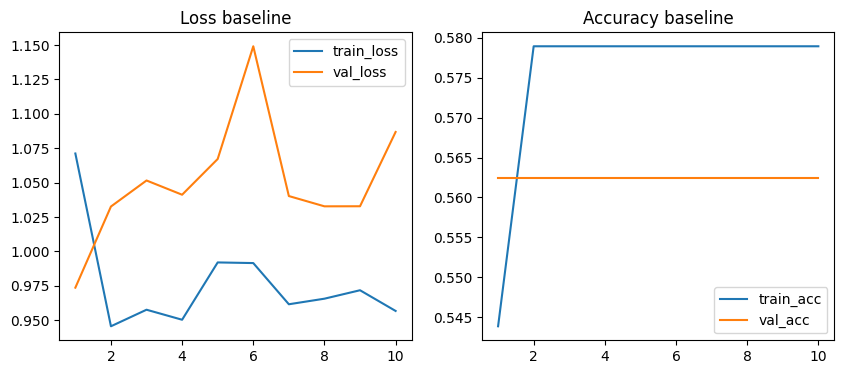

Final val_loss=0.9737 val_acc=0.5625
Classification report:
              precision    recall  f1-score   support

   butterfly     0.0000    0.0000    0.0000         3
   dragonfly     0.0000    0.0000    0.0000         4
        moth     0.5625    1.0000    0.7200         9

    accuracy                         0.5625        16
   macro avg     0.1875    0.3333    0.2400        16
weighted avg     0.3164    0.5625    0.4050        16



D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

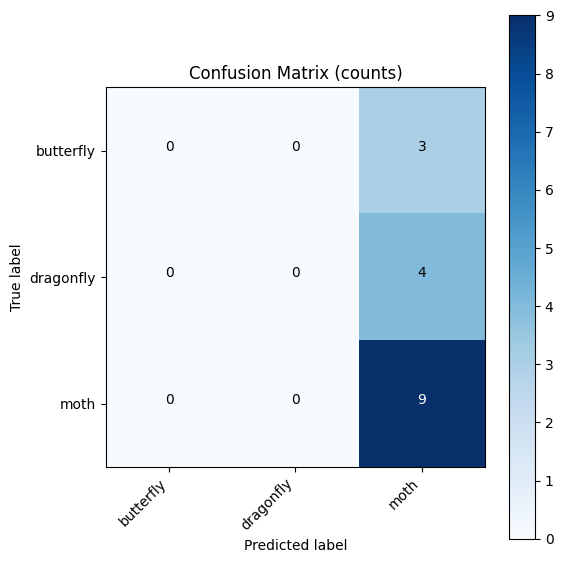

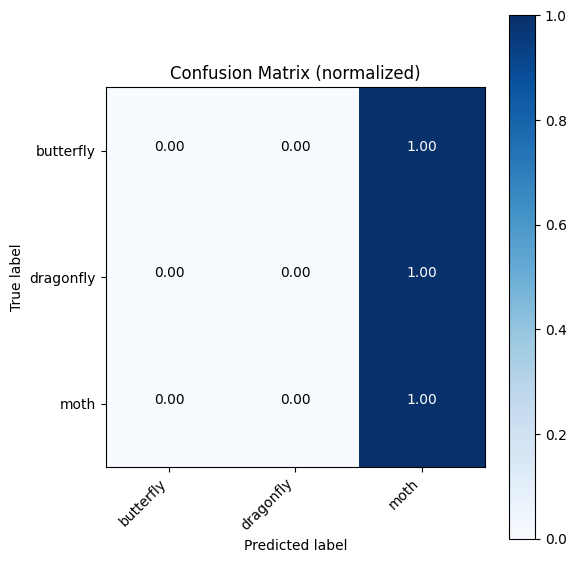

Run mode: vgg_direct
Classes: ['butterfly', 'dragonfly', 'moth']


D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | train_loss=2.9909 acc=0.4561 | val_loss=1.1305 acc=0.2500 | time=7.3s
Epoch 2/10 | train_loss=1.4296 acc=0.2982 | val_loss=0.9929 acc=0.5625 | time=7.4s
Epoch 3/10 | train_loss=1.0064 acc=0.5789 | val_loss=0.9720 acc=0.5625 | time=7.1s
Epoch 4/10 | train_loss=1.1661 acc=0.5789 | val_loss=1.0064 acc=0.5625 | time=6.4s
Epoch 5/10 | train_loss=1.4209 acc=0.4912 | val_loss=1.0087 acc=0.5625 | time=7.1s
Epoch 6/10 | train_loss=1.0243 acc=0.5789 | val_loss=0.9456 acc=0.5625 | time=6.7s
Epoch 7/10 | train_loss=1.0668 acc=0.5789 | val_loss=0.9848 acc=0.5625 | time=7.0s
Epoch 8/10 | train_loss=1.0007 acc=0.5789 | val_loss=0.9863 acc=0.5625 | time=6.8s
Epoch 9/10 | train_loss=0.9766 acc=0.5789 | val_loss=1.0016 acc=0.5625 | time=7.0s
Epoch 10/10 | train_loss=0.9840 acc=0.5789 | val_loss=0.9922 acc=0.5625 | time=7.1s


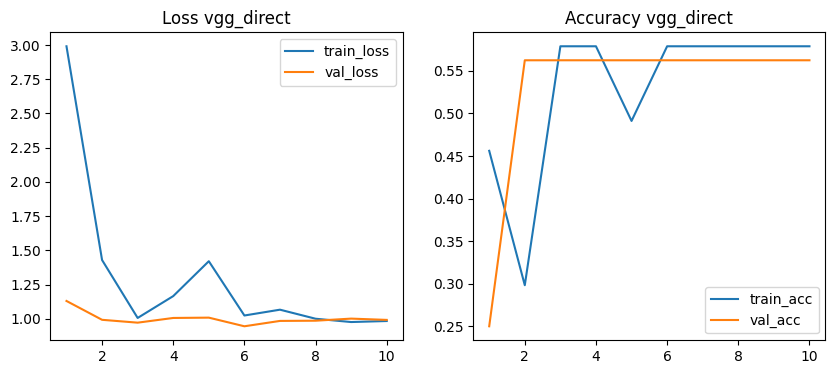

Final val_loss=0.9929 val_acc=0.5625
Classification report:
              precision    recall  f1-score   support

   butterfly     0.0000    0.0000    0.0000         3
   dragonfly     0.0000    0.0000    0.0000         4
        moth     0.5625    1.0000    0.7200         9

    accuracy                         0.5625        16
   macro avg     0.1875    0.3333    0.2400        16
weighted avg     0.3164    0.5625    0.4050        16



D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

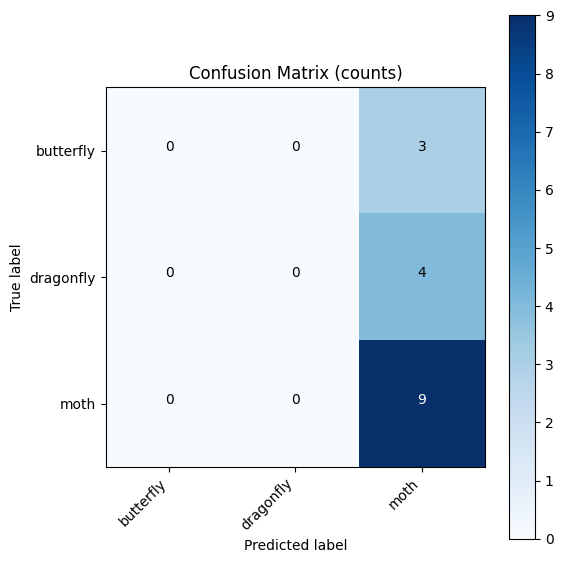

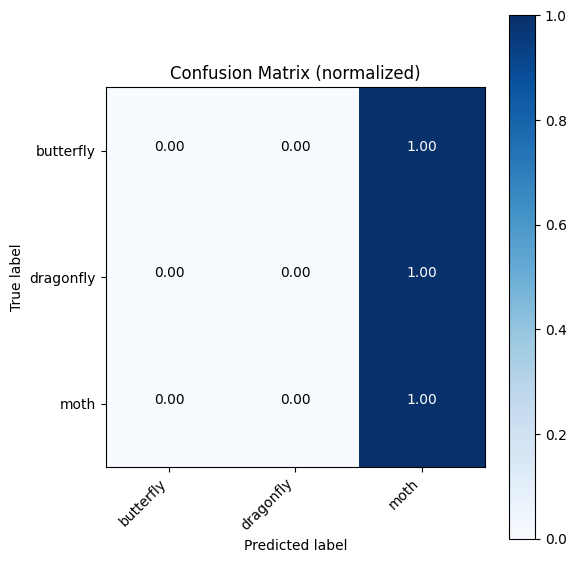

Run mode: vgg_feat
Classes: ['butterfly', 'dragonfly', 'moth']


D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | train_loss=6.0532 acc=0.4211 | val_loss=2.4559 acc=0.4375 | time=6.5s
Epoch 2/10 | train_loss=1.3926 acc=0.6842 | val_loss=3.5674 acc=0.6250 | time=6.5s
Epoch 3/10 | train_loss=2.1906 acc=0.7193 | val_loss=2.3160 acc=0.5625 | time=5.4s
Epoch 4/10 | train_loss=0.5611 acc=0.8596 | val_loss=1.8548 acc=0.7500 | time=5.4s
Epoch 5/10 | train_loss=0.3104 acc=0.9474 | val_loss=1.4167 acc=0.8125 | time=5.6s
Epoch 6/10 | train_loss=0.8750 acc=0.8772 | val_loss=1.2183 acc=0.8750 | time=5.4s
Epoch 7/10 | train_loss=0.7427 acc=0.9123 | val_loss=1.3425 acc=0.8125 | time=5.2s
Epoch 8/10 | train_loss=0.7763 acc=0.8421 | val_loss=1.2604 acc=0.8750 | time=5.3s
Epoch 9/10 | train_loss=0.1898 acc=0.9298 | val_loss=1.3500 acc=0.8125 | time=5.3s
Epoch 10/10 | train_loss=0.4793 acc=0.9298 | val_loss=1.6793 acc=0.8125 | time=5.2s


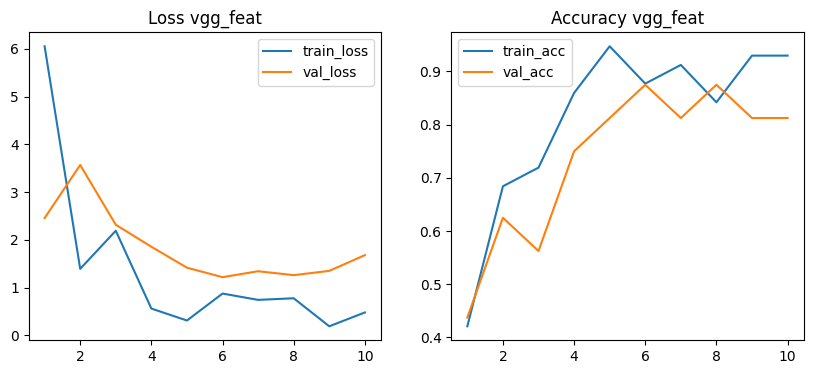

Final val_loss=1.2183 val_acc=0.8750
Classification report:
              precision    recall  f1-score   support

   butterfly     1.0000    0.3333    0.5000         3
   dragonfly     1.0000    1.0000    1.0000         4
        moth     0.8182    1.0000    0.9000         9

    accuracy                         0.8750        16
   macro avg     0.9394    0.7778    0.8000        16
weighted avg     0.8977    0.8750    0.8500        16



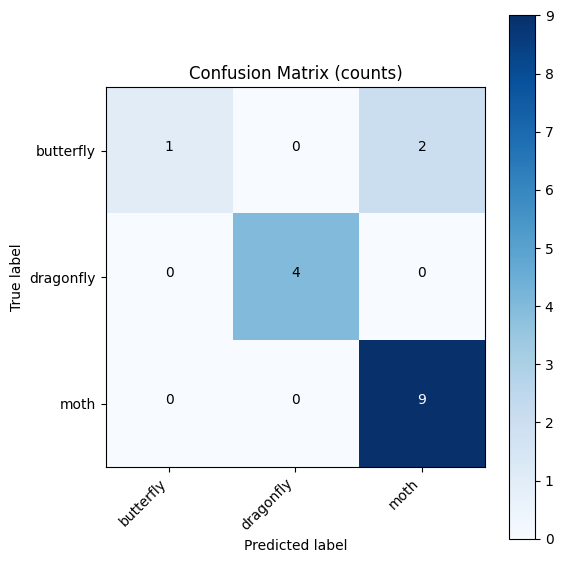

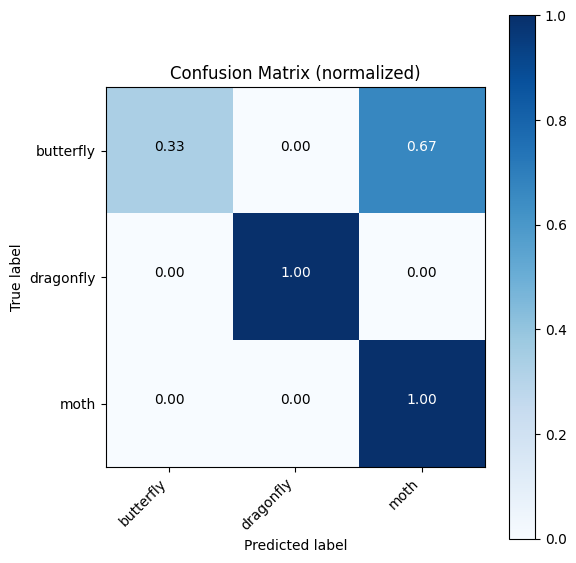

Run mode: vgg_finetune
Classes: ['butterfly', 'dragonfly', 'moth']


D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | train_loss=3.0653 acc=0.3860 | val_loss=1.2525 acc=0.2500 | time=5.9s
Epoch 2/10 | train_loss=1.4641 acc=0.4386 | val_loss=0.9806 acc=0.5625 | time=5.9s
Epoch 3/10 | train_loss=1.0651 acc=0.5789 | val_loss=1.0548 acc=0.5625 | time=5.3s
Epoch 4/10 | train_loss=1.0793 acc=0.5789 | val_loss=1.0107 acc=0.5625 | time=5.3s
Epoch 5/10 | train_loss=0.9416 acc=0.5789 | val_loss=0.9753 acc=0.5625 | time=5.5s
Epoch 6/10 | train_loss=1.2236 acc=0.5789 | val_loss=1.4384 acc=0.5625 | time=5.5s
Epoch 7/10 | train_loss=1.2209 acc=0.5789 | val_loss=1.0092 acc=0.5625 | time=5.4s
Epoch 8/10 | train_loss=0.9271 acc=0.5789 | val_loss=2.6581 acc=0.5625 | time=5.4s
Epoch 9/10 | train_loss=1.0676 acc=0.3509 | val_loss=1.2037 acc=0.1875 | time=5.2s
Epoch 10/10 | train_loss=1.0848 acc=0.4035 | val_loss=1.0298 acc=0.5625 | time=5.3s


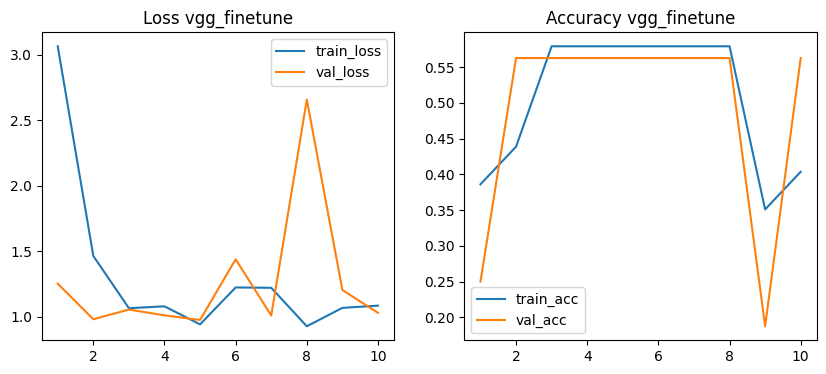

Final val_loss=0.9806 val_acc=0.5625
Classification report:
              precision    recall  f1-score   support

   butterfly     0.0000    0.0000    0.0000         3
   dragonfly     0.0000    0.0000    0.0000         4
        moth     0.5625    1.0000    0.7200         9

    accuracy                         0.5625        16
   macro avg     0.1875    0.3333    0.2400        16
weighted avg     0.3164    0.5625    0.4050        16



D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

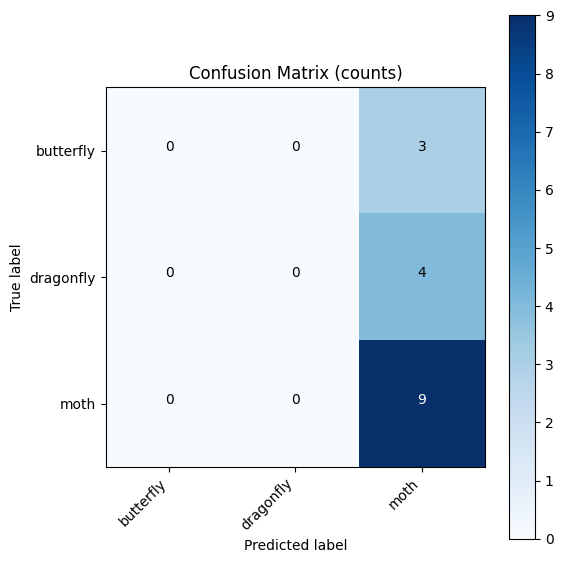

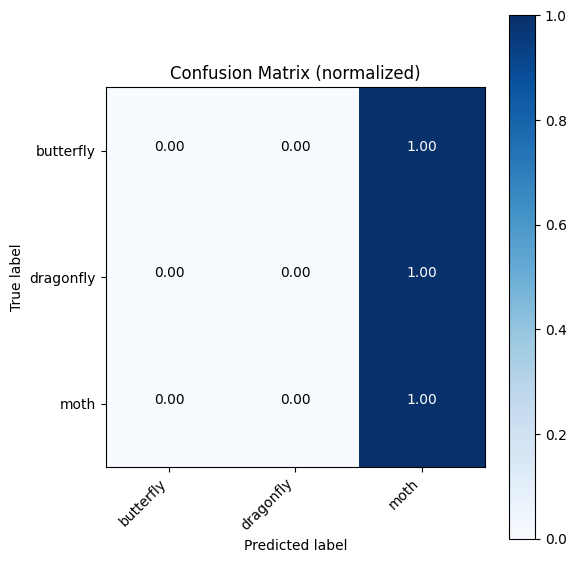

Run mode: resnet50
Classes: ['butterfly', 'dragonfly', 'moth']


D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\MyFiles\Projects\learn-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | train_loss=1.0049 acc=0.4561 | val_loss=55.7903 acc=0.5625 | time=5.4s
Epoch 2/10 | train_loss=0.9638 acc=0.6842 | val_loss=31.0307 acc=0.6250 | time=5.4s
Epoch 3/10 | train_loss=0.8300 acc=0.6491 | val_loss=32.7459 acc=0.6875 | time=5.3s
Epoch 4/10 | train_loss=0.4869 acc=0.8596 | val_loss=70.4215 acc=0.5000 | time=5.3s
Epoch 5/10 | train_loss=0.5890 acc=0.7719 | val_loss=179.6510 acc=0.5625 | time=5.2s
Epoch 6/10 | train_loss=0.6642 acc=0.7719 | val_loss=48.1887 acc=0.6250 | time=5.3s
Epoch 7/10 | train_loss=0.4709 acc=0.8421 | val_loss=5.1795 acc=0.7500 | time=5.2s
Epoch 8/10 | train_loss=0.5133 acc=0.8246 | val_loss=2.7480 acc=0.6875 | time=5.2s
Epoch 9/10 | train_loss=0.5087 acc=0.7895 | val_loss=2.7681 acc=0.6875 | time=5.1s
Epoch 10/10 | train_loss=0.6101 acc=0.7368 | val_loss=5.7737 acc=0.6875 | time=5.2s


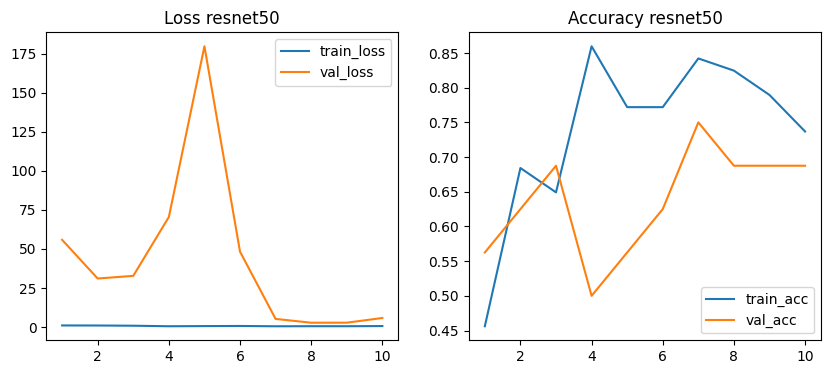

Final val_loss=5.1795 val_acc=0.7500
Classification report:
              precision    recall  f1-score   support

   butterfly     1.0000    0.3333    0.5000         3
   dragonfly     1.0000    0.5000    0.6667         4
        moth     0.6923    1.0000    0.8182         9

    accuracy                         0.7500        16
   macro avg     0.8974    0.6111    0.6616        16
weighted avg     0.8269    0.7500    0.7206        16



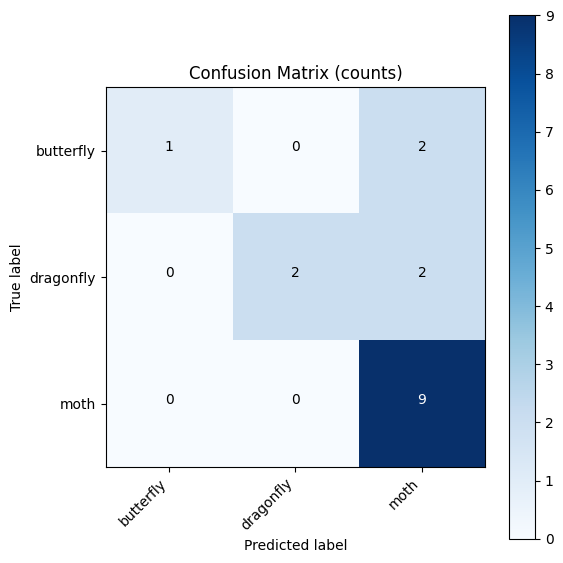

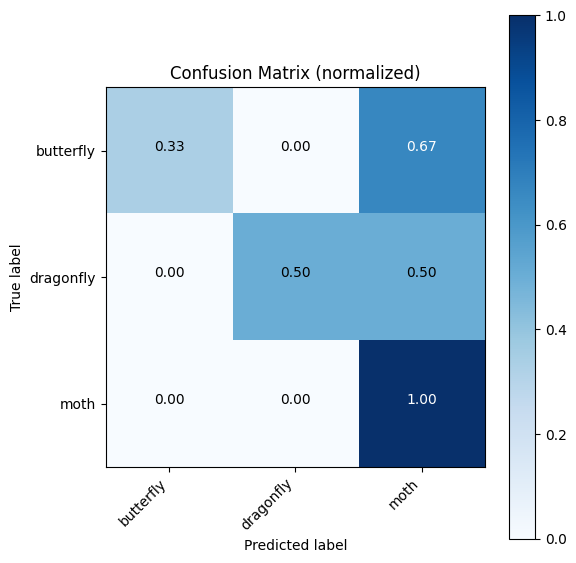

Summary:
           mode  val_acc  val_loss
0      baseline   0.5625  0.973737
1    vgg_direct   0.5625  0.992866
2      vgg_feat   0.8750  1.218322
3  vgg_finetune   0.5625  0.980605
4      resnet50   0.7500  5.179500


In [37]:
# ----------  使用示例（按步运行） ----------
# 1) 爬取图片，取消下一行注释并运行（需要网络）
# crawl_images(categories, num_per_class, RAW_DIR, CRAWL_BACKEND)

# 2) 清洗并划分（运行后会在 DATA_DIR 下创建 train/val）
clean_and_split(RAW_DIR, DATA_DIR, VAL_SPLIT)

# 3) 检查数据后运行一个实验
# model, history, classes = run_experiment("baseline", DATA_DIR, RESULTS_DIR/"baseline", epochs=10)
# plot_history(history, "baseline")
# final_eval_and_report(model, DATA_DIR)

# 4) 一次跑全部（耗时较长）
summary_df = run_all_experiments(DATA_DIR, RESULTS_DIR, epochs=10)

# End of notebook